<!-- # Task 2: 3D Reconstruction [30] -->

<!-- **Please go through the notebook once before beginning working on it!** -->

<!-- In this notebook, we will extend our work from Task 1 to reconstruct a 3D model of a landmark using multiple images from the Heritage-Recon dataset. -->

<!-- <span style="color: red">**Submission Guidelines:**</span> Only one member of each group has to submit the file on LMS. The name of the file should be your group number. For example, if you are Group 1 then the file name should be **G01_Deliverable1.ipynb**. If you are unsure about your group number, then you can confirm it in the [sheet](https://docs.google.com/spreadsheets/d/1vN6JOLDWoFR5BnXTr0lMYGv_e9VzyAbqSUqf4VdjCQI/edit?gid=0#gid=0). -->

<!-- #### Imports -->

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.optimize import least_squares

# add imports here
from read_write_model import read_cameras_binary, read_images_binary, read_points3D_binary
from IPython.display import clear_output

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<!-- ##### **Helper Functions** -->

In [459]:
def get_img_paths(folder_pth):
    """Returns a list containing filenames of all jpg files in folder_pth"""
    jpg_files = []

    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            # uncomment the line below if you want to include the entire path in the filename
            filename = os.path.join(folder_pth, filename)
            jpg_files.append(filename)

    return jpg_files

def load_images(folder_pth):
    """Loads all images in folder_path"""
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg") or filename.lower().endswith(".png"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)

    return images

def resize_image(img, size=(800, 600)):
    """Resizes image to a specified size."""
    return cv2.resize(img, size)

# Image functions
def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_image_dict(folder_path, preprocess=False):
    image_dict = {}
    
    for image_idx, image_name in enumerate(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, image_name)
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        
        rsz_img = resize_image(img)
        
        if not preprocess:
            image_dict[image_idx] = [rsz_img, image_name]

        else:
            # Converting to grayscale
            grayscale_image = convert_to_grayscale(rsz_img)

            # # Normalizing the intensity
            # normalized_image = normalize_intensity(grayscale_image)

            # # Applying equalize histogram
            # equalized_image = equalize_histogram(normalized_image)

            # # Applying Gaussian blur
            # blurred_image = gaussian_blur(equalized_image)

            image_dict[image_idx] = [grayscale_image, image_name]
    
    return image_dict       

# Display functions
def show_image(image):
    plt.figure(figsize=(10, 7))
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def show_images(image_list):
    fig, ax = plt.subplots(1, len(image_list), figsize=(5*len(image_list), 5))
    ax.flatten()
    
    for image_idx, image in enumerate(image_list):
        ax[image_idx].imshow(image)
        ax[image_idx].axis('off')
        
    plt.tight_layout()
    plt.show()

def show_images_and_semantic(image_list):
    fig, ax = plt.subplots(1, len(image_list), figsize=(5*len(image_list), 5))
    ax.flatten()
    
    image, semantic_map = image_list
    ax[0].imshow(image)
    ax[0].axis('off')
    
    ax[1].imshow(semantic_map)
    ax[1].axis('off')
        
    plt.tight_layout()
    plt.show()

# Camera functions 
def create_K_matrix(focal_lengths, principal_points):
    fx, fy = focal_lengths[0], focal_lengths[1]
    px, py = principal_points[0], principal_points[1]
    K = np.array([
        [fx, 0,  px],
        [0,  fy, py],
        [0,  0,  1],
    ])

    return K

def find_intrinsic(images_bin, cameras_bin, name):
    K = None
    for image_id, image in images_bin.items():
        
        # Finding image id with matched name
        if image.name == name:
            
            # Fetching camera
            cam = cameras_bin[image_id]
            
            # Getting info from camera parameters
            focal_lengths = (cam.params[0], cam.params[1])  
            principal_points = (cam.params[2], cam.params[3])
            
            # Creating intrinsic matrix K
            K = create_K_matrix(focal_lengths, principal_points)
            break
    assert K is not None, "No intrinsice matrix found"
    return K, image.name

def compute_projection_matrix(K, R, T):
    RT = np.hstack((R, T))
    P = np.dot(K, RT)
    return P 

def normalize_points(pts, K):
    k_inv = np.linalg.inv(K)
    points_homogenous = np.hstack((pts, np.ones((pts.shape[0], 1))))
    
    normalized_pts = (k_inv @ points_homogenous.T).T
    valid_depths = normalized_pts[:, 2] > 0
    
    return normalized_pts[valid_depths][:, :2]

def linear_triangulation(P1, P2, masked_pts1, masked_pts2):
    points_3d = []
    for pts1, pts2 in zip(masked_pts1, masked_pts2):
        u1, v1 = pts1
        u2, v2 = pts2
        
        A = np.zeros((4, 4))
        A[0] = u1 * P1[2, :] - P1[0, :]
        A[1] = v1 * P1[2, :] - P1[1, :]
        A[2] = u2 * P2[2, :] - P2[0, :]
        A[3] = v2 * P2[2, :] - P2[1, :]

        _, _, Vt = np.linalg.svd(A)
        
        point_3d = Vt[-1] / Vt[-1, 3]
        points_3d.append(point_3d)
    
    return np.array(points_3d)    
    
def recover_camera_pose(E, pts1, pts2):
    # SVD of E to get R and T
    U, S, Vt = np.linalg.svd(E)
    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1
    
    W = np.array([[0, -1, 0], 
                  [1,  0, 0], 
                  [0,  0, 1]])
    
    # Generating the four combinations for R and T
    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt
    T = U[:, 2]
    
    if np.linalg.det(R1) < 0:
        R1 *= -1
    if np.linalg.det(R2) < 0:
        R2 *= -1

    # 4 possible solutions for camera orientation
    RnT_solutions = [
        (R1, T),
        (R1, -T),
        (R2, T),
        (R2, -T)
    ]
    return RnT_solutions

def disambiguate_camera_pose(RnT_solutions, pts1, pts2):
    for R, T in RnT_solutions:
        P1 = np.hstack((np.eye(3), [[0], [0], [0]]))
        P2 = np.hstack((R, T.reshape(-1, 1)))
        
        # Normalized homogenous 3d coordinates
        points_4d = linear_triangulation(P1, P2, pts1, pts2)
        points_3d = points_4d[:, :3] / points_4d[:, 3:4]
        
        # Checking if depth is positive for the 3d points
        if np.all(points_3d[:, 2] > 0):
            print("correct R and T")
            return R, T
        else:
            print("Incorrect R and T")

def reprojection_loss_fn(params, inlier_pts1, inlier_pts2):
    # Reshaping the flattened 3D points    
    
    P1 = params[0:12].reshape(-1, 4)
    P2 = params[12:24].reshape(-1, 4)
    points_3d = params[24:].reshape(-1, 4)
    points_3d /= points_3d[:, 3:4]

    # Reprojecting 3d points to 2d
    points_2d_reproj_1 = (P1 @ points_3d.T).T
    points_2d_reproj_1 /= points_2d_reproj_1[:, 2:3]
    
    points_2d_reproj_2 = (P2 @ points_3d.T).T
    points_2d_reproj_2 /= points_2d_reproj_2[:, 2:3]
    
    # Computing projection errors
    residuals_1 = inlier_pts1 - points_2d_reproj_1[:, :2]
    residuals_2 = inlier_pts2 - points_2d_reproj_2[:, :2]
    
    residuals = np.hstack((
        residuals_1,
        residuals_2
    ))
    return residuals.ravel()

def bundle_adjustment(points_3d, inlier_pts1, inlier_pts2, P1, P2, max_nfev=50, verbose=2):
    params = np.hstack((
        P1.ravel(),
        P2.ravel(),
        points_3d.ravel()
    ))
    
    optimized_params = least_squares(
        reprojection_loss_fn,
        params,
        args=(inlier_pts1, inlier_pts2),
        max_nfev=max_nfev,
        verbose=verbose,
        )
    
    P1 = optimized_params.x[0:12].reshape(3, 4)
    P2 = optimized_params.x[12:24].reshape(3, 4)
    points_3d = optimized_params.x[24:].reshape(-1, 4)
    
    return P1, P2, points_3d

def orient_points(all_points_3d, x_scale=1, y_scale=1, z_scale=1, reorder='swap', num_pairs=1):
    point_cloud = np.vstack(all_points_3d[:num_pairs])
    
    if reorder=='swap':
        swapped_pcd = point_cloud[:, [0, 2, 1]]
        scaled_swapped_pcd = swapped_pcd
    else:
        scaled_swapped_pcd = point_cloud
    
    scaled_swapped_pcd[:, 0] = x_scale*scaled_swapped_pcd[:, 0]
    scaled_swapped_pcd[:, 1] = y_scale*scaled_swapped_pcd[:, 1]
    scaled_swapped_pcd[:, 2] = z_scale*scaled_swapped_pcd[:, 2]
    
    return scaled_swapped_pcd

<!-- ### Dataset Loading & Preprocessing
Similar to what we did in Task 1, but instead of only a few images, we will now load in and preprocess all the images in our dataset -->

In [460]:
# images_folder_path = "./lincoln_memorial/dense/images"

# # Loading images and preprocessed images
# image_dict = get_image_dict(images_folder_path)
# preprocessed_image_dict = get_image_dict(images_folder_path, True)


<!-- **Displaying some images with its corresponding preprocessed images** -->

image name: 1089429421_3526e57ab4_o.jpg - idx 8
pre-processed image name 1089429421_3526e57ab4_o.jpg


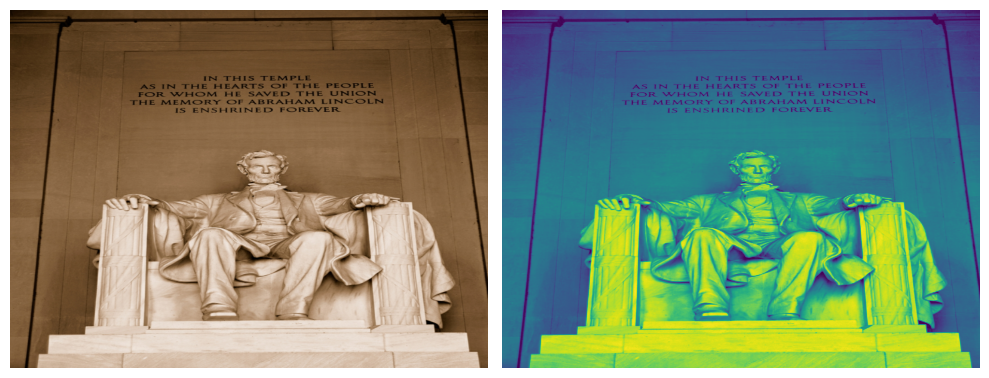

image name: 1107268770_37c4ea7502_o.jpg - idx 17
pre-processed image name 1107268770_37c4ea7502_o.jpg


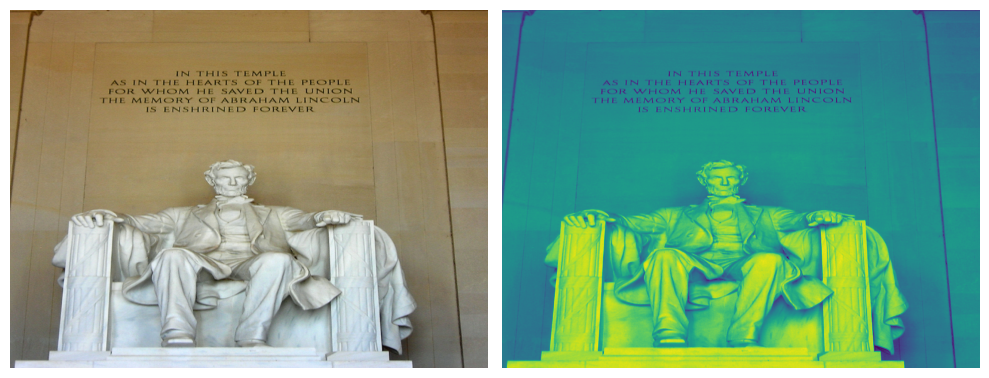

image name: 1463047101_12054f1c08_o.jpg - idx 84
pre-processed image name 1463047101_12054f1c08_o.jpg


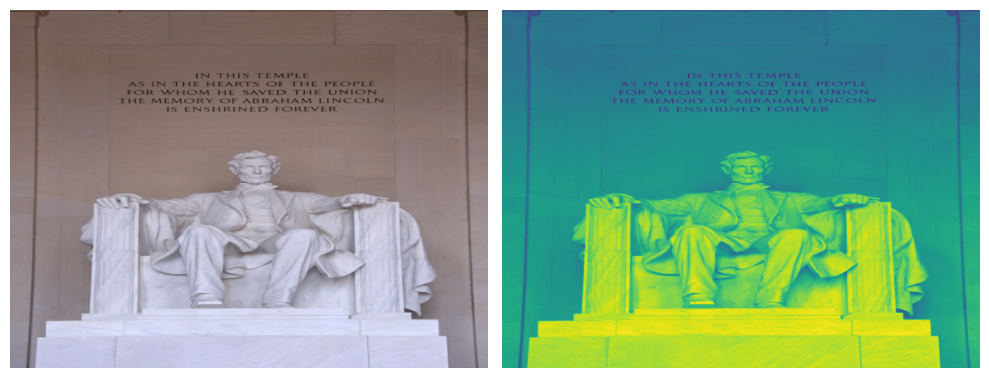

In [461]:
# Selecting specific images and displaying some of them

image_indices = [8, 17, 84, 43, 263, 287]
# image_indices = [8, 17, 263]
# image_indices = [17, 263]
image_indices = [8, 17, 84]

images = []
p_images = []
for img_idx in image_indices:
    # if img_idx % 5 == 0:
    img, name = image_dict[img_idx]
    img_p, name_p = preprocessed_image_dict[img_idx]
    print(f"image name: {name} - idx {img_idx}\npre-processed image name {name_p}")
    show_images([img, img_p])
    

<!-- ### Feature Detection & Matching (Across Multiple Images)
Extending what we did in Task 1, we will now extract the features from each image and match these features across all the images. However, this time you might want to consider extracting the best matches instead of all of them for each pair. Using the best matches improves the accuracy and reliability of our feature matching, which is crucial for the success of subsequent stages. Filtering out bad matches reduces the chance of errors propagating throughout the pipeline and results in a more robust and accurate 3D model.

Also display the results of feature detection and matching for any pair of images. -->

<!-- **Getting all keypoints and descriptors of each selected image** -->

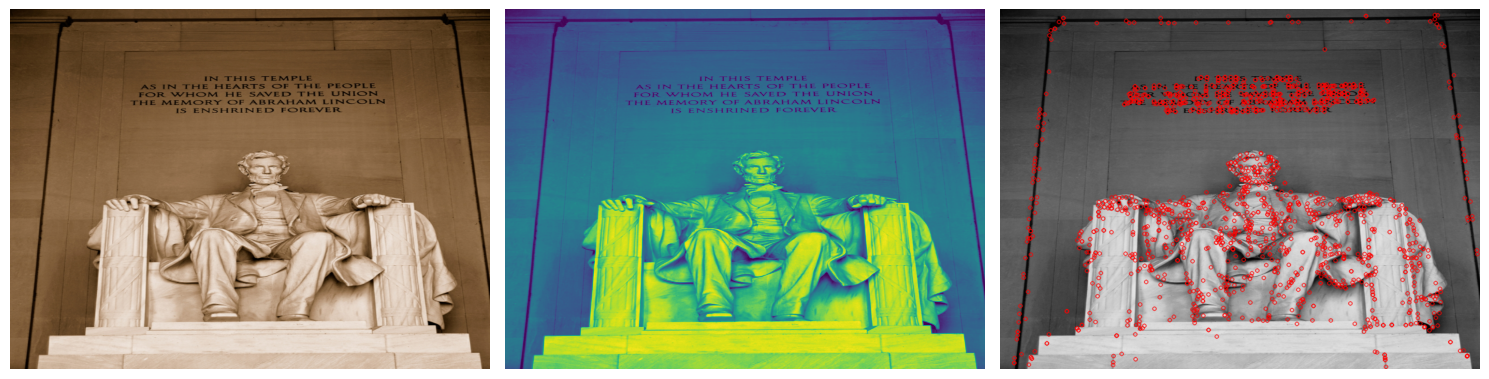

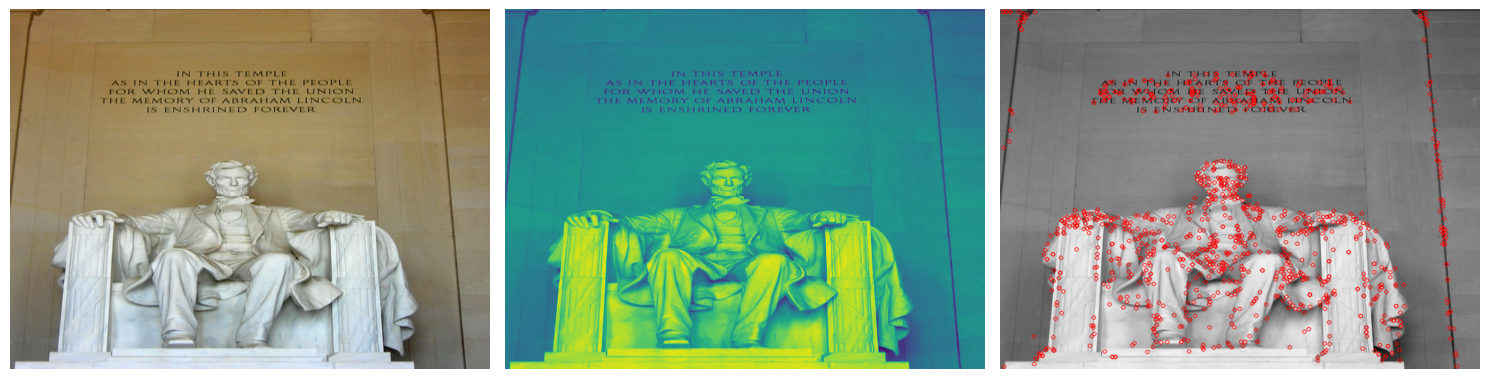

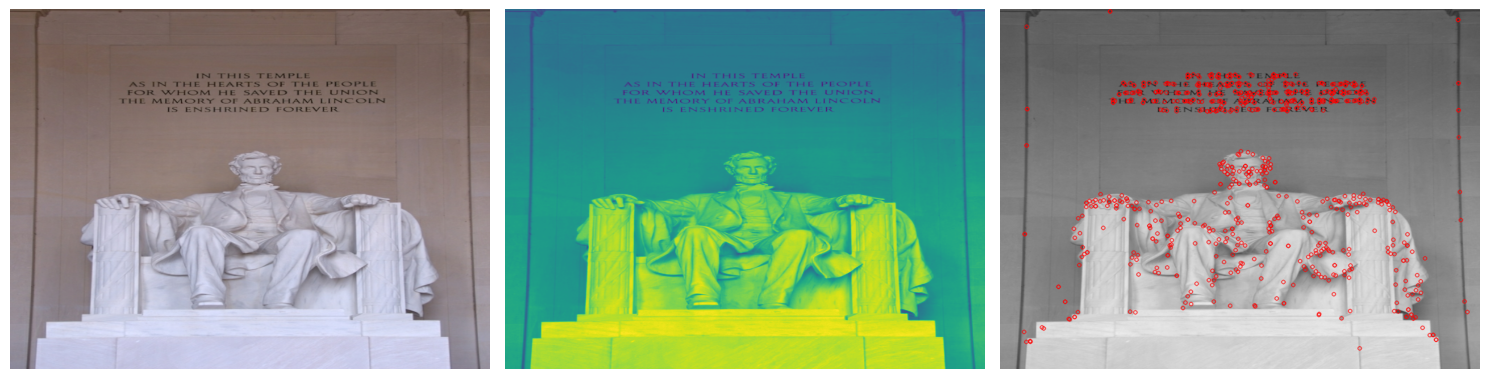

In [462]:
def get_image_features(detector_type, image_indices, image_dict, preprocessed_image_dict):
    # Dictionary to store info: keypoints, descriptors, image name
    feature_dict = {}
    
    if detector_type == "orb":
        orb = cv2.ORB_create()
            
    elif detector_type == "sift":
        sift = cv2.SIFT_create()
    
    # Loop for finding keypoints and descriptors of the selected images
    for img_idx in image_indices:
        image, name = image_dict[img_idx]
        image_pp, name_pp = preprocessed_image_dict[img_idx]
        assert name == name_pp
        if detector_type == "orb":
            kp, desc = orb.detectAndCompute(image_pp, None)
                
        elif detector_type == "sift":
            kp, desc = sift.detectAndCompute(image_pp, None)
        
        # Saving keypoints
        feature_dict[img_idx] = [kp, desc, name_pp]
        
        # Displaying image with keypoints
        image_kp = cv2.drawKeypoints(image_pp.copy(), kp, image.copy(), color=(255, 0, 0))
        show_images([image, image_pp, image_kp])

    return feature_dict       

detector_type = "sift"
feature_dict = get_image_features(detector_type, image_indices, image_dict, preprocessed_image_dict)

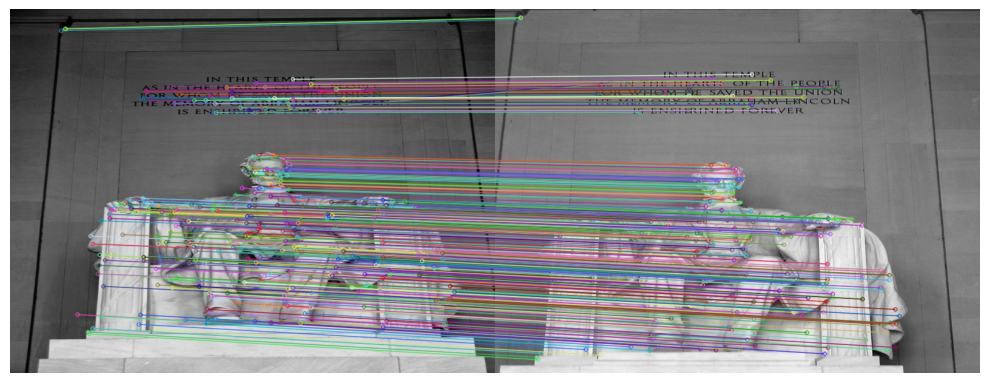

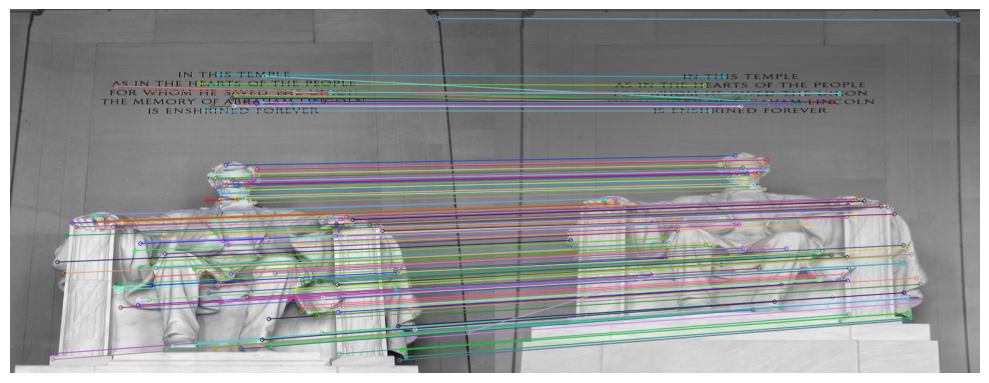

In [463]:
def get_image_matches(detector_type, image_indices, feature_dict, threshold_ratio=0.75):
    match_dict = {}

    idx_1 = image_indices[0]
    for idx, idx_2 in enumerate(image_indices[1:]):
        kp1, desc1, name1 = feature_dict[idx_1]
        kp2, desc2, name2 = feature_dict[idx_2]
        
        if detector_type == "orb":
            matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = matcher.match(desc1, desc2)   
            
            # Filtering      
            num_matches = int(len(matches)*threshold_ratio)
            filtered_matches = sorted(matches, key=lambda x:x.distance)[:num_matches]
        
        elif detector_type == "sift":
            matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
            matches = matcher.knnMatch(desc1, desc2, k=2)
           
            # Filtering      
            filtered_matches = [m for m, n in matches if m.distance < n.distance * threshold_ratio]

        elif detector_type == 'flann':
            index_params = dict(algorithm=1, trees=5)
            search_params = dict(checks=50)
            flann = cv2.FlannBasedMatcher(index_params, search_params)
            
            matches = flann.knnMatch(desc1, desc2, k=2)
            
            filtered_matches = [m for m, n in matches if m.distance < n.distance * threshold_ratio]
            
        # Adding to dictionary
        image1_pp, name1_pp = preprocessed_image_dict[idx_1]
        image2_pp, name2_pp = preprocessed_image_dict[idx_2]
        
        assert name1_pp == name1, "Incorrect matches for image"
        match_dict[idx_1] = [filtered_matches, name1]
    
        # Visualizing the matches for each pair
        # clear_output(wait=True)
        matched_image = cv2.drawMatches(image1_pp, kp1, image2_pp, kp2, filtered_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        show_image(matched_image)

        # Updating for next image pair
        idx_1 = idx_2
        
    return match_dict

detector_type = 'sift'
match_dict = get_image_matches(detector_type, image_indices, feature_dict, threshold_ratio=0.60)

In [464]:
# CHECK
for (filtered_matches, name_m), (kp, desc, name_f) in zip(match_dict.values(), feature_dict.values()): 
    assert name_m == name_f, "Incorrect matches for features"

<!-- ### Camera Pose Estimation (Global)
We will estimate the relative camera poses (position and orientation) between consecutive image pairs. You can use the same technique as you did in Task 1 or switch to one of the others mentioned in the announcement on Slack. -->

In [465]:
# # COLMAP
# sfm_folder = './lincoln_memorial/neuralsfm'
# cameras_bin = os.path.join(sfm_folder, 'cameras.bin')
# images_bin = os.path.join(sfm_folder, 'images.bin')
# points3D_bin = os.path.join(sfm_folder, 'points3D.bin')

# # Parsing the sfm files
# def parse_files(cameras_bin, images_bin, points3D_bin):
#     cameras_bin = read_cameras_binary(cameras_bin)
#     images_bin = read_images_binary(images_bin)
#     points3D_bin = read_points3D_binary(points3D_bin)
    
#     return cameras_bin, images_bin, points3D_bin

# cameras_bin, images_bin, points3D_bin = parse_files(cameras_bin, images_bin, points3D_bin)

In [466]:
preview = 1

print("Cameras:")
for idx, (cam_id, cam) in enumerate(cameras_bin.items()):
    if idx == preview:
        break
    print(f"Camera ID: {cam_id} - Model: {cam.model} - Width: {cam.width} - Height: {cam.height} - Focal length: ({cam.params[0]}, {cam.params[1]}) - Principal point: ({cam.params[2]}, {cam.params[3]})")
    
print("\nImage:")
for idx, (image_id, image) in enumerate(images_bin.items()):
    if idx == preview:
        break
    print(f"Image ID: {image_id} - Name: {image.name} - Camera ID: {image.camera_id}")
    
print("\nPoints3D:")
for idx, (pt_id, pt) in enumerate(points3D_bin.items()):
    if idx == preview:
        break
    print(f"Points ID: {pt_id} - Coordinates: {pt.xyz}")

Cameras:
Camera ID: 708 - Model: PINHOLE - Width: 1600 - Height: 1182 - Focal length: (1628.6739393939395, 1628.5904347826088) - Principal point: (800.0, 591.0)

Image:
Image ID: 708 - Name: 3323997727_3eddea30f4_o.jpg - Camera ID: 708

Points3D:
Points ID: 4015734 - Coordinates: [-3.36310092 -4.72929749  8.63601629]


In [467]:
def get_instrinsics_poses_inliers(image_indices, feature_dict, match_dict, images_bin, cameras_bin):
    # Intrinsic dictionary to store intrinsic matrices for each selected image
    intrinsic_dict = {}
    
    # Camera pose dictionary to store fundamental matrix F, essential matrix E, 
    # rotation matrix R, and translation matrix T
    camera_pose_dict = {}
    
    # Inlier dictionary to store inlier points
    inlier_pts_dict = {}
    
    idx_1 = image_indices[0]
    for idx, idx_2 in enumerate(image_indices[1:]):
        kp1, desc1, name1 = feature_dict[idx_1]
        kp2, desc2, name2 = feature_dict[idx_2]
        
        # Creating fundamental matrix F
        matches, name_m = match_dict[idx_1]
        assert name1 == name_m, "Incorrect features for matches"
        
        matched_points_1 = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float32)
        matched_points_2 = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float32)

        F, mask = cv2.findFundamentalMat(matched_points_1, matched_points_2, method=cv2.FM_RANSAC)

        # Taking inlier points and disgarding outlier points
        masked_pts1 = matched_points_1[mask.ravel() == 1]
        masked_pts2 = matched_points_2[mask.ravel() == 1]
        
        # Getting instrinsic matrices
        K1, img1_name = find_intrinsic(images_bin, cameras_bin, name1)
        assert img1_name == name1, "Incorrect intrinsic matrix for image1"
        
        K2, img2_name = find_intrinsic(images_bin, cameras_bin, name2)
        assert img2_name == name2, "Incorrect intrinsic matrix for image2"

        # Adding intrinsic matrices to intrinsic dict
        intrinsic_dict[idx_1] = [K1, img1_name]
        intrinsic_dict[idx_2] = [K2, img2_name]
        
        # Normalizing the masked points
        norm_pts1 = normalize_points(masked_pts1, K1)
        norm_pts2 = normalize_points(masked_pts2, K2)
        # inlier_pts_dict[idx_1] = [norm_pts1, norm_pts2]
        inlier_pts_dict[idx_1] = [masked_pts1, masked_pts2]
        
        # Computing essential matrix
        E = K2.T @ F @ K1 
        
        # Finding correct rotation and translation
        RnT_solutions = recover_camera_pose(E, masked_pts1, masked_pts2)
        R, T = disambiguate_camera_pose(RnT_solutions, masked_pts1, masked_pts2)

        camera_pose_dict[idx_1] = [F, E, R, T.reshape(-1, 1)]
        
        # Updating for next image pair
        idx_1 = idx_2
        
    return intrinsic_dict, camera_pose_dict, inlier_pts_dict

intrinsic_dict, camera_pose_dict, inlier_pts_dict = get_instrinsics_poses_inliers(
    image_indices, feature_dict, match_dict, images_bin, cameras_bin
    )

correct R and T
correct R and T


<!-- ### Choosing the technique
For this task, you have been given the choice of using either Structure from Motion (SfM) or Photogrammetry as your reconstruction method. A brief overview of the steps involved in each technique has been included in the handout provided to you. You can choose either technique for this task but before you choose one be sure to do a bit more research on each technique. I have also added some resources below to help you in understanding each technique.

[Understanding Structure From Motion Algorithms](https://medium.com/@loboateresa/understanding-structure-from-motion-algorithms-fc034875fd0c)\
[SfM](https://cmsc426.github.io/sfm/)\
[Chapter 13 - Structure from motion](https://mi.eng.cam.ac.uk/~cipolla/publications/contributionToEditedBook/2008-SFM-chapters.pdf)\
[What is Photogrammetry?](https://www.artec3d.com/learning-center/what-is-photogrammetry)\
[The Multi-View Environment](https://github.com/simonfuhrmann/mve)\
[open Multi-View Stereo](https://github.com/cdcseacave/openMVS)\
[Surface Reconstruction](https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html)

**Technique chosen:** SFM -->

<!-- ### 3D Reconstruction
Once you have chosen the technique, you can now start working on actually 3D reconstruction. Depending on the technique, follow the pipeline to generate the 3D point cloud for your landmark. -->

In [468]:
print(f"features: {len(feature_dict)} - Keys: {feature_dict.keys()}")
print(f"matches: {len(match_dict)} - Keys: {match_dict.keys()}")
print(f"camera pose: {len(camera_pose_dict)} - Keys: {camera_pose_dict.keys()}")
print(f"intrinsics: {len(intrinsic_dict)} - Keys: {intrinsic_dict.keys()}")

features: 3 - Keys: dict_keys([8, 17, 84])
matches: 2 - Keys: dict_keys([8, 17])
camera pose: 2 - Keys: dict_keys([8, 17])
intrinsics: 3 - Keys: dict_keys([8, 17, 84])


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.6837e+04                                    5.67e+06    
       1              9         9.0440e+03      4.78e+04       3.90e-01       3.52e+06    
       2             10         6.5509e+03      2.49e+03       7.79e-01       2.38e+06    
       3             11         9.9703e+02      5.55e+03       7.79e-01       8.16e+05    
       4             12         4.2879e+02      5.68e+02       1.56e+00       4.83e+05    
       5             13         5.0009e+01      3.79e+02       1.56e+00       7.76e+04    
       6             15         3.9973e+01      1.00e+01       7.79e-01       1.20e+04    
       7             17         3.9203e+01      7.70e-01       3.90e-01       2.42e+03    
       8             18         3.8327e+01      8.76e-01       7.79e-01       9.68e+03    
       9             19         3.8107e+01      2.19e-01       1.56e+00       3.12e+04    

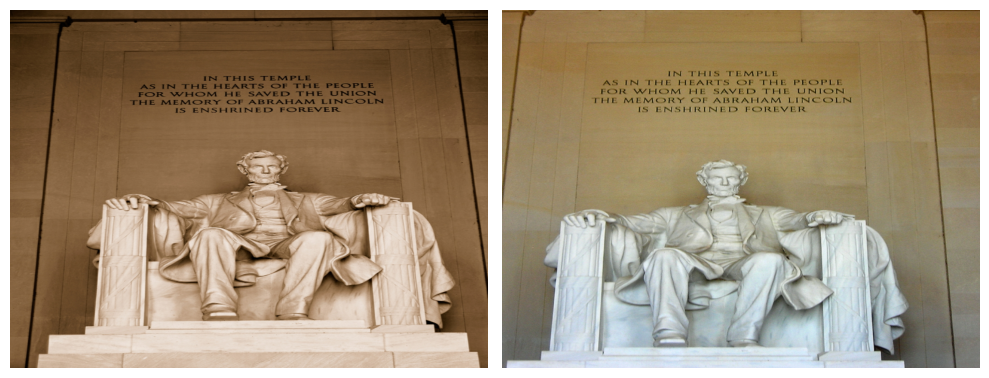

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3306e+07                                    1.23e+07    
       1              6         1.0872e+07      2.43e+06       2.42e+01       6.26e+06    
       2              7         5.5293e+06      5.34e+06       6.05e+00       5.24e+06    
       3              8         1.2674e+06      4.26e+06       6.05e+00       1.28e+06    
       4             10         4.4996e+05      8.17e+05       3.03e+00       2.14e+05    
       5             11         2.8782e+05      1.62e+05       6.05e+00       4.46e+05    
       6             13         2.0312e+05      8.47e+04       3.03e+00       7.27e+04    
       7             14         1.4723e+05      5.59e+04       6.05e+00       1.70e+05    
       8             15         1.0999e+05      3.72e+04       1.21e+01       3.44e+05    
       9             16         6.7289e+04      4.27e+04       1.21e+01       3.66e+04    

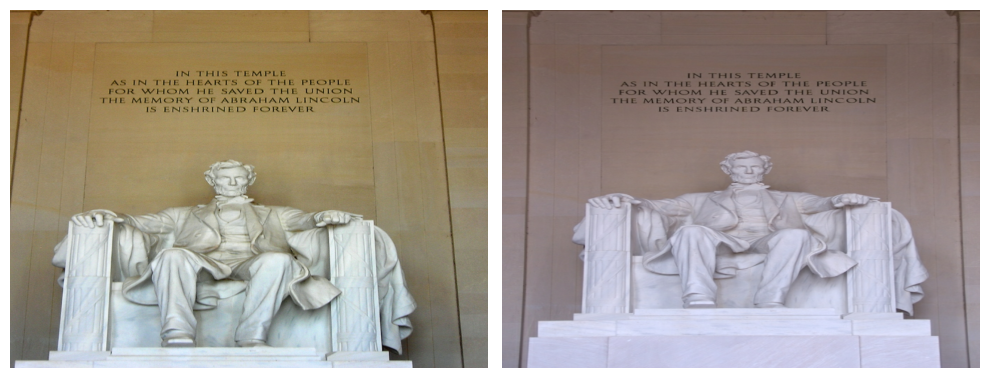

In [469]:
all_points_3d = []

name1 = ""
for idx, idx_2 in enumerate(image_indices[1:]):
    if name1 == "":
        idx_1 = image_indices[0]
        K1, name1 = intrinsic_dict[idx_1]
        R1, T1 = np.eye(3), np.zeros((3, 1)) 
        P1 = compute_projection_matrix(K1, R1, T1)
        
    # Computing projection matrix for cam2
    K2, name2 = intrinsic_dict[idx_2]
    F, E, R, T = camera_pose_dict[idx_1]
    
    # Computing absolute pose of second camera
    R2 = R @ R1
    T2 = T1 + (R1 @ T)
    
    P2 = compute_projection_matrix(K2, R2, T2)
        
    # Linear Triangulation - inlier_pts are normalized
    inlier_pts1, inlier_pts2 = inlier_pts_dict[idx_1]
    points_3d = linear_triangulation(P1, P2, inlier_pts1, inlier_pts2)

    # Optimizing the 3D points and P2
    P1, P2, points_3d = bundle_adjustment(points_3d, inlier_pts1, inlier_pts2, P1, P2, max_nfev=100, verbose=2)

    # Converting 4D homogenous coordinates to 3D
    points_3d_homogenous = points_3d / points_3d[:, 3:4]
    points_3d = points_3d_homogenous[:, :3]
    
    # Reprojecting 3d points to both images for evaluation
    points_2d_reproj_1 = (P1 @ points_3d_homogenous.T).T
    points_2d_reproj_1 /= points_2d_reproj_1[:, 2:3]

    points_2d_reproj_2 = (P2 @ points_3d_homogenous.T).T
    points_2d_reproj_2 /= points_2d_reproj_2[:, 2:3]

    # Calculating reprojection error
    error_1 = np.linalg.norm(points_2d_reproj_1[:, :2] - inlier_pts1, axis=1)
    error_2 = np.linalg.norm(points_2d_reproj_2[:, :2] - inlier_pts2, axis=1)

    print(f"Reprojection error in image {idx}:", np.mean(error_1))
    print(f"Reprojection error in image {idx+1}:", np.mean(error_2))
    
    # Adding optimized points to 3d point cloud
    all_points_3d.append(points_3d)
    
    img1, img1_name = image_dict[idx_1][0].copy(), image_dict[idx_1][1]
    assert name1 == img1_name, f"Intrinsic mismatch for {name1}"
    
    img2, img2_name = image_dict[idx_2][0].copy(), image_dict[idx_2][1]
    assert name2 == img2_name, f"Intrinsic mismatch for {name2}"
    
    idx_1 = idx_2
    name1 = name2
    K1 = K2
    R1, T1 = R2, T2
    P1 = P2
    
    # Displaying reprojected points on image pair
    show_images([img1, img2])

<!-- ### Mesh Generation & Texturing
Convert the 3D points generated into a 3D mesh and apply textures to it. You can use techniques like Poisson Surface Reconstruction for creating the mesh. For texturing, project the images onto the mesh based on the camera poses. -->

<!-- ### Visualization
Visualize the 3D model once you have generated it -->

**3D Visualization**

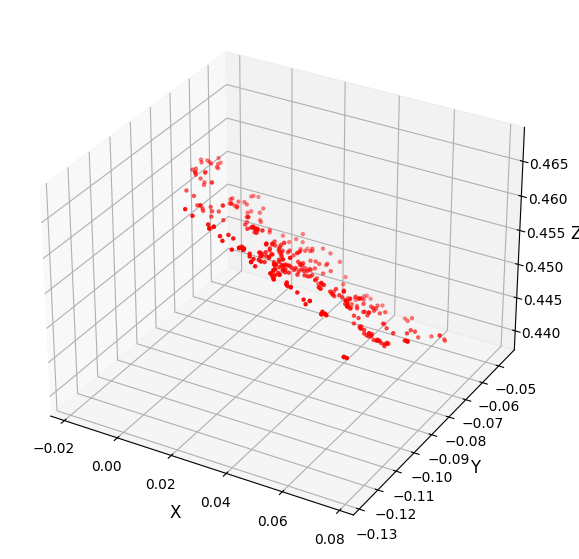

In [470]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


point_cloud = orient_points(all_points_3d, 1, -1, -1, False, len(all_points_3d)-1)
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c='red', s=5)

ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Z', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()


<!-- ### Save your model
Save the results from the 3D reconstruction process, which includes:

- The 3D point cloud data (sparse or dense depending on the method you used).
- The camera poses (rotation and translation matrices).
  
This step is essential for documenting and visualizing your results, and also for use in the final task. You can save the data in formats like .ply for point clouds or .obj for meshes, and save the matrices in standard formats like .npz (for NumPy arrays). -->

**Point-cloud Visualization with Open3d**

In [471]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
o3d.visualization.draw_geometries([pcd])

**Saving the point cloud**

In [472]:
def save_pointcloud(path, point_cloud):

    point_cloud_o3d = o3d.geometry.PointCloud()
    point_cloud_o3d.points = o3d.utility.Vector3dVector(point_cloud)

    # Save the point cloud in PLY format
    o3d.io.write_point_cloud(path, point_cloud_o3d)
    
ply_path = "point_cloud_3D.ply"
if False:
    save_pointcloud(ply_path, point_cloud)

In [473]:
np.savez('intrinsic_camera_data.npz', 
    intrinsic_dict=intrinsic_dict, 
    camera_pose_dict=camera_pose_dict, 
    )

**Surface reconstruction of point cloud**

In [3]:
def load_and_display_pointcloud(path):
    point_cloud = o3d.io.read_point_cloud(path) 
    o3d.visualization.draw_geometries([point_cloud]) 
    
# Loading the file to make sure everything is correct
ply_path = "point_cloud_3D_2.ply"
if True:
    load_and_display_pointcloud(ply_path)

<!-- ### Evaluation
Evaluate the quality of your model. You can talk about how successfully you were able to reconstruct the landmark including aspects such as geometry accuracy, completeness, and texture detail (An answer of 5-6 lines will suffice).

**ANS:** The quality was reasonable, with the head, legs, and chair being visible. The accuracy of my model greatly depending on the images being selected. Images that were similar gave a more visible landmark reconstruction. Moreover, choosing accuracte matching features also played a crucial part. Just changing the threshold for matching from 0.65 to 0.7 or 0.6 changes the whole image reconstruction. -->